<a href="https://colab.research.google.com/github/sj442/Predict-Calorie-Expenditure/blob/main/s5e5_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploads

In [ ]:
from google.colab import files
files.upload()

# Imports

In [2]:
! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# Download datasets

In [ ]:
# Synthetic dataset for competition
! kaggle competitions download -c playground-series-s5e5

# Original dataset
! kaggle datasets download ruchikakumbhar/calories-burnt-prediction

In [5]:
import zipfile

with zipfile.ZipFile('playground-series-s5e5.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

with zipfile.ZipFile('calories-burnt-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

In [6]:
df_train = pd.read_csv('/content/kaggle/train.csv')
df_original = pd.read_csv('/content/kaggle/calories.csv')

df_test = pd.read_csv('/content/kaggle/test.csv')

# High level stats

In [ ]:
df_train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [44]:
numerical_columns = df_train.select_dtypes(include =['int64', 'float64']).columns.to_list()
numerical_columns.remove('id')
categorical_columns = df_train.select_dtypes(include =['object']).columns

In [ ]:
df_train.describe().round(2)

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.00,750000.00,750000.00,750000.00,750000.00,750000.00,750000.00,750000.00
mean,374999.50,41.42,174.70,75.15,15.42,95.48,40.04,88.28
std,216506.50,15.18,12.82,13.98,8.35,9.45,0.78,62.40
min,0.00,20.00,126.00,36.00,1.00,67.00,37.10,1.00
25%,187499.75,28.00,164.00,63.00,8.00,88.00,39.60,34.00
50%,374999.50,40.00,174.00,74.00,15.00,95.00,40.30,77.00
75%,562499.25,52.00,185.00,87.00,23.00,103.00,40.70,136.00
max,749999.00,79.00,222.00,132.00,30.00,128.00,41.50,314.00


In [ ]:
df_original.describe().round(2)

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,14977358.54,42.79,174.47,74.97,15.53,95.52,40.03,89.54
std,2872851.45,16.98,14.26,15.04,8.32,9.58,0.78,62.46
min,10001159.00,20.00,123.00,36.00,1.00,67.00,37.10,1.00
25%,12474190.75,28.00,164.00,63.00,8.00,88.00,39.60,35.00
50%,14997285.00,39.00,175.00,74.00,16.00,96.00,40.20,79.00
75%,17449278.75,56.00,185.00,87.00,23.00,103.00,40.60,138.00
max,19999647.00,79.00,222.00,132.00,30.00,128.00,41.50,314.00


In [ ]:
df_train.describe(include='object')

,Sex
count,750000
unique,2
top,female
freq,375721


In [ ]:
df_original.describe(include='object')

,Gender
count,15000
unique,2
top,female
freq,7553


# Univariate Analysis

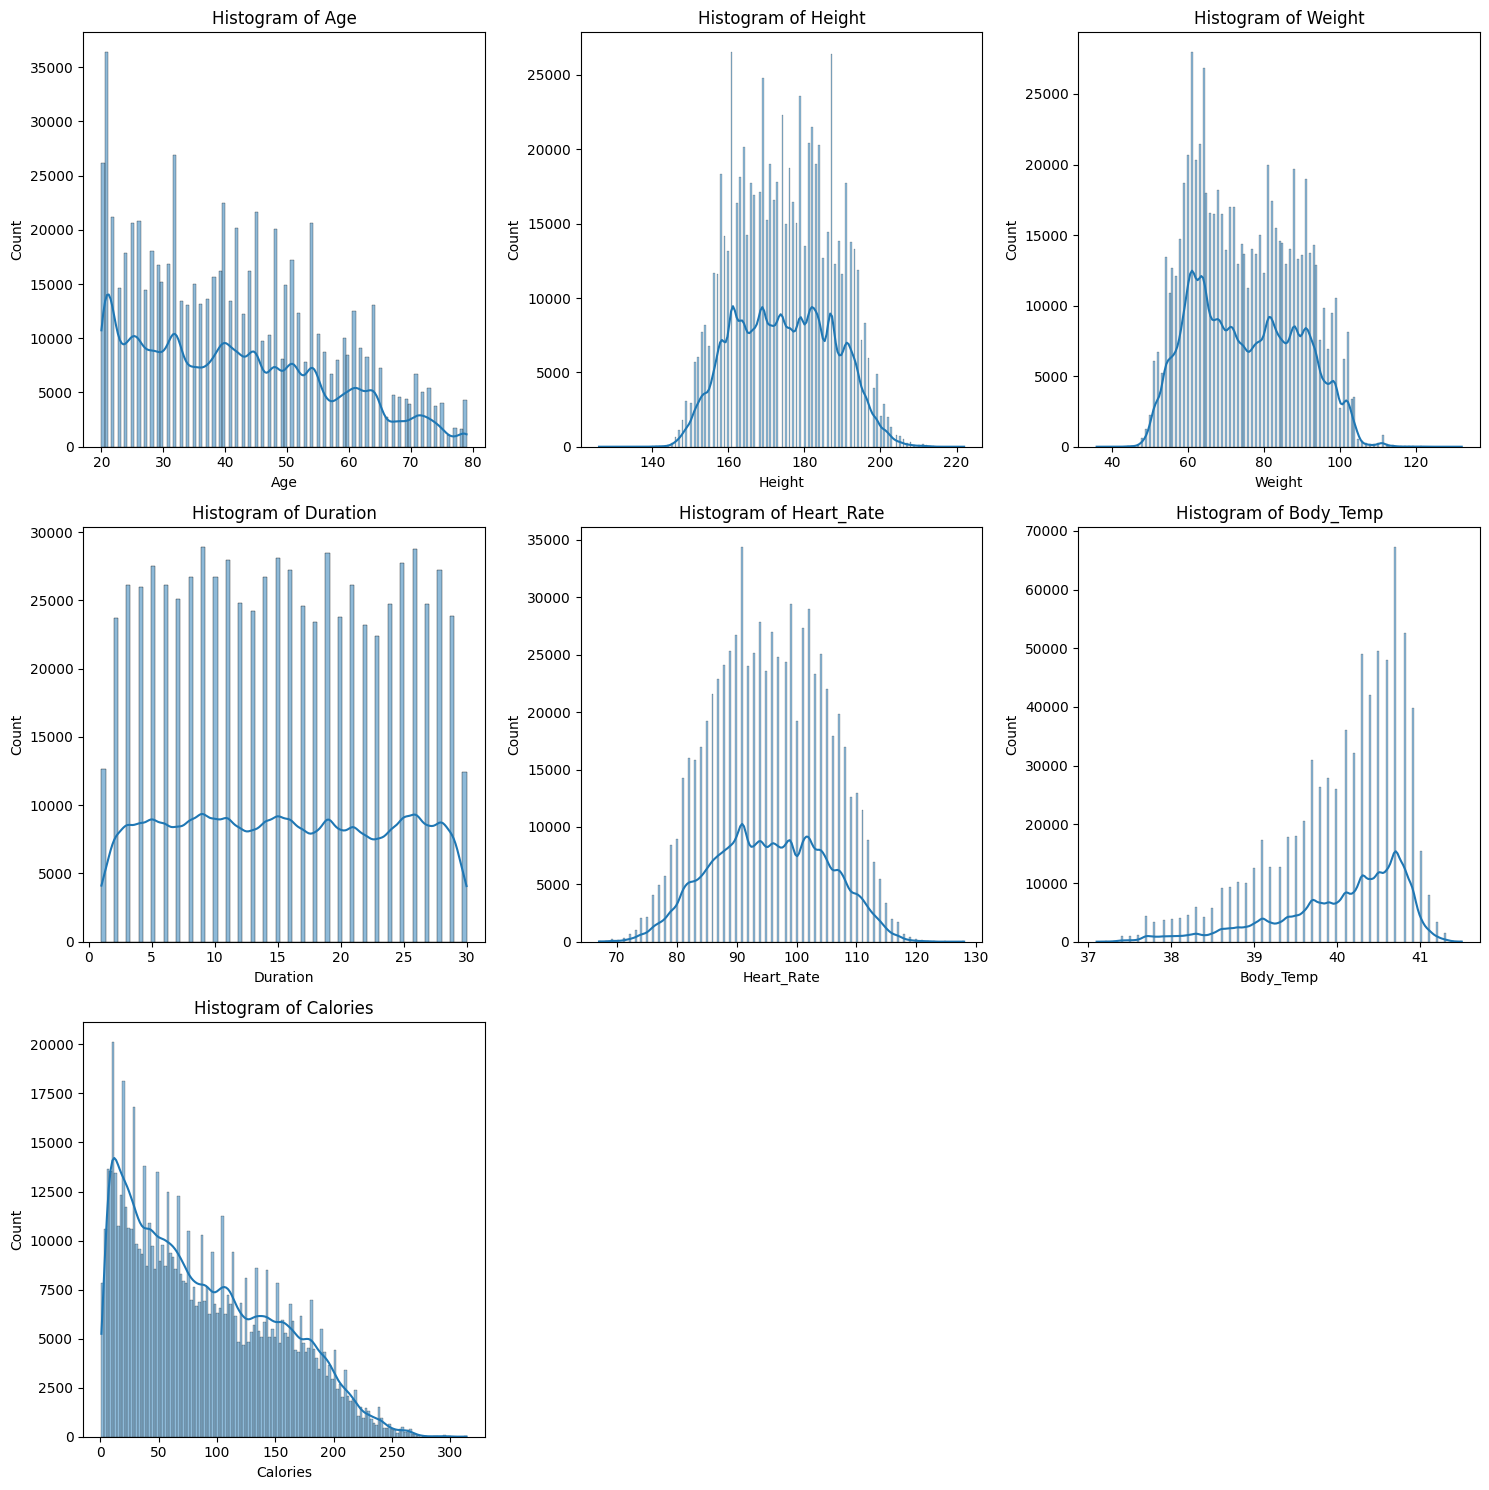

In [19]:
num_features = len(numerical_columns)
cols = 3  # Number of columns in the grid
rows = (num_features // cols) + (num_features % cols > 0)  # Dynamically determine rows

# Set figure size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()  # Flatten in case of 2D array

# Plot each feature's boxplot
for i, feature in enumerate(numerical_columns):
  sns.histplot(data=df_train, x=feature, palette='viridis', kde = True, ax=axes[i])
  axes[i].set_title(f"Histogram of {feature}")

# Hide any unused subplots (if num_features < rows * cols)
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])  # Remove empty plots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

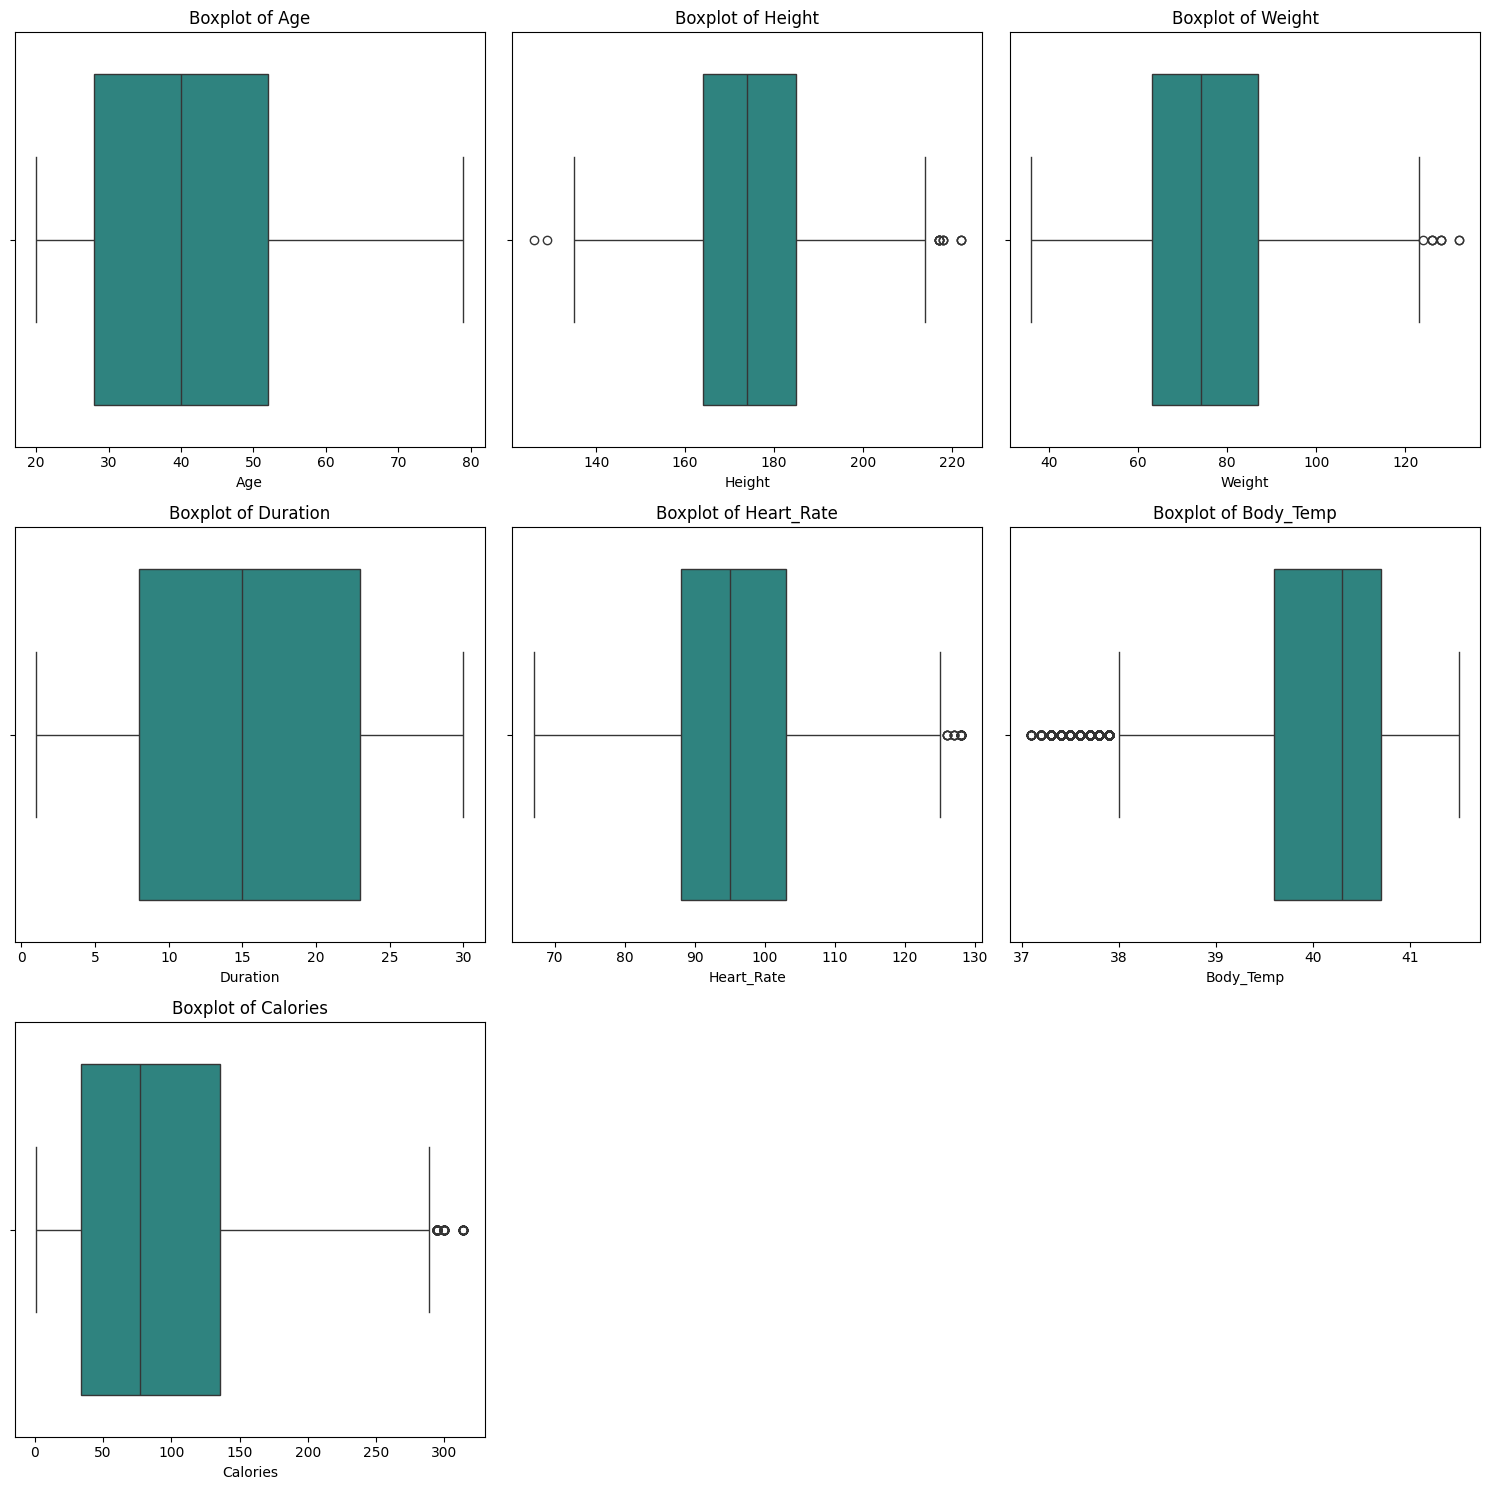

In [21]:
num_features = len(numerical_columns)
cols = 3  # Number of columns in the grid
rows = (num_features // cols) + (num_features % cols > 0)  # Dynamically determine rows

# Set figure size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()  # Flatten in case of 2D array

# Plot each feature's boxplot
for i, feature in enumerate(numerical_columns):
  sns.boxplot(data=df_train, x=feature, palette='viridis', ax=axes[i])
  axes[i].set_title(f"Boxplot of {feature}")

# Hide any unused subplots (if num_features < rows * cols)
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])  # Remove empty plots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Note: There are some outliers present in the target variable, and some features.
Consider removing the outliers before running models

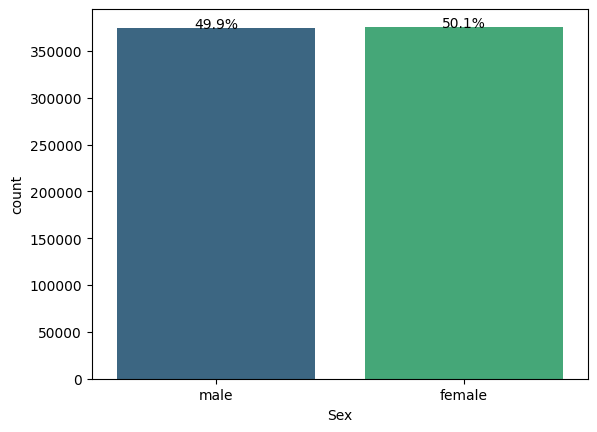

In [28]:
# Calculate total count
total = df_train.shape[0]

# Create the countplot
ax = sns.countplot(x='Sex', data=df_train, palette='viridis')

# Annotate the bars with percentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 4
    ax.annotate(percentage, (x, y), ha='center')

# Display the plot
plt.show()

Pretty equally divided between the genders. Females have a small majority

# Bivariate Analysis

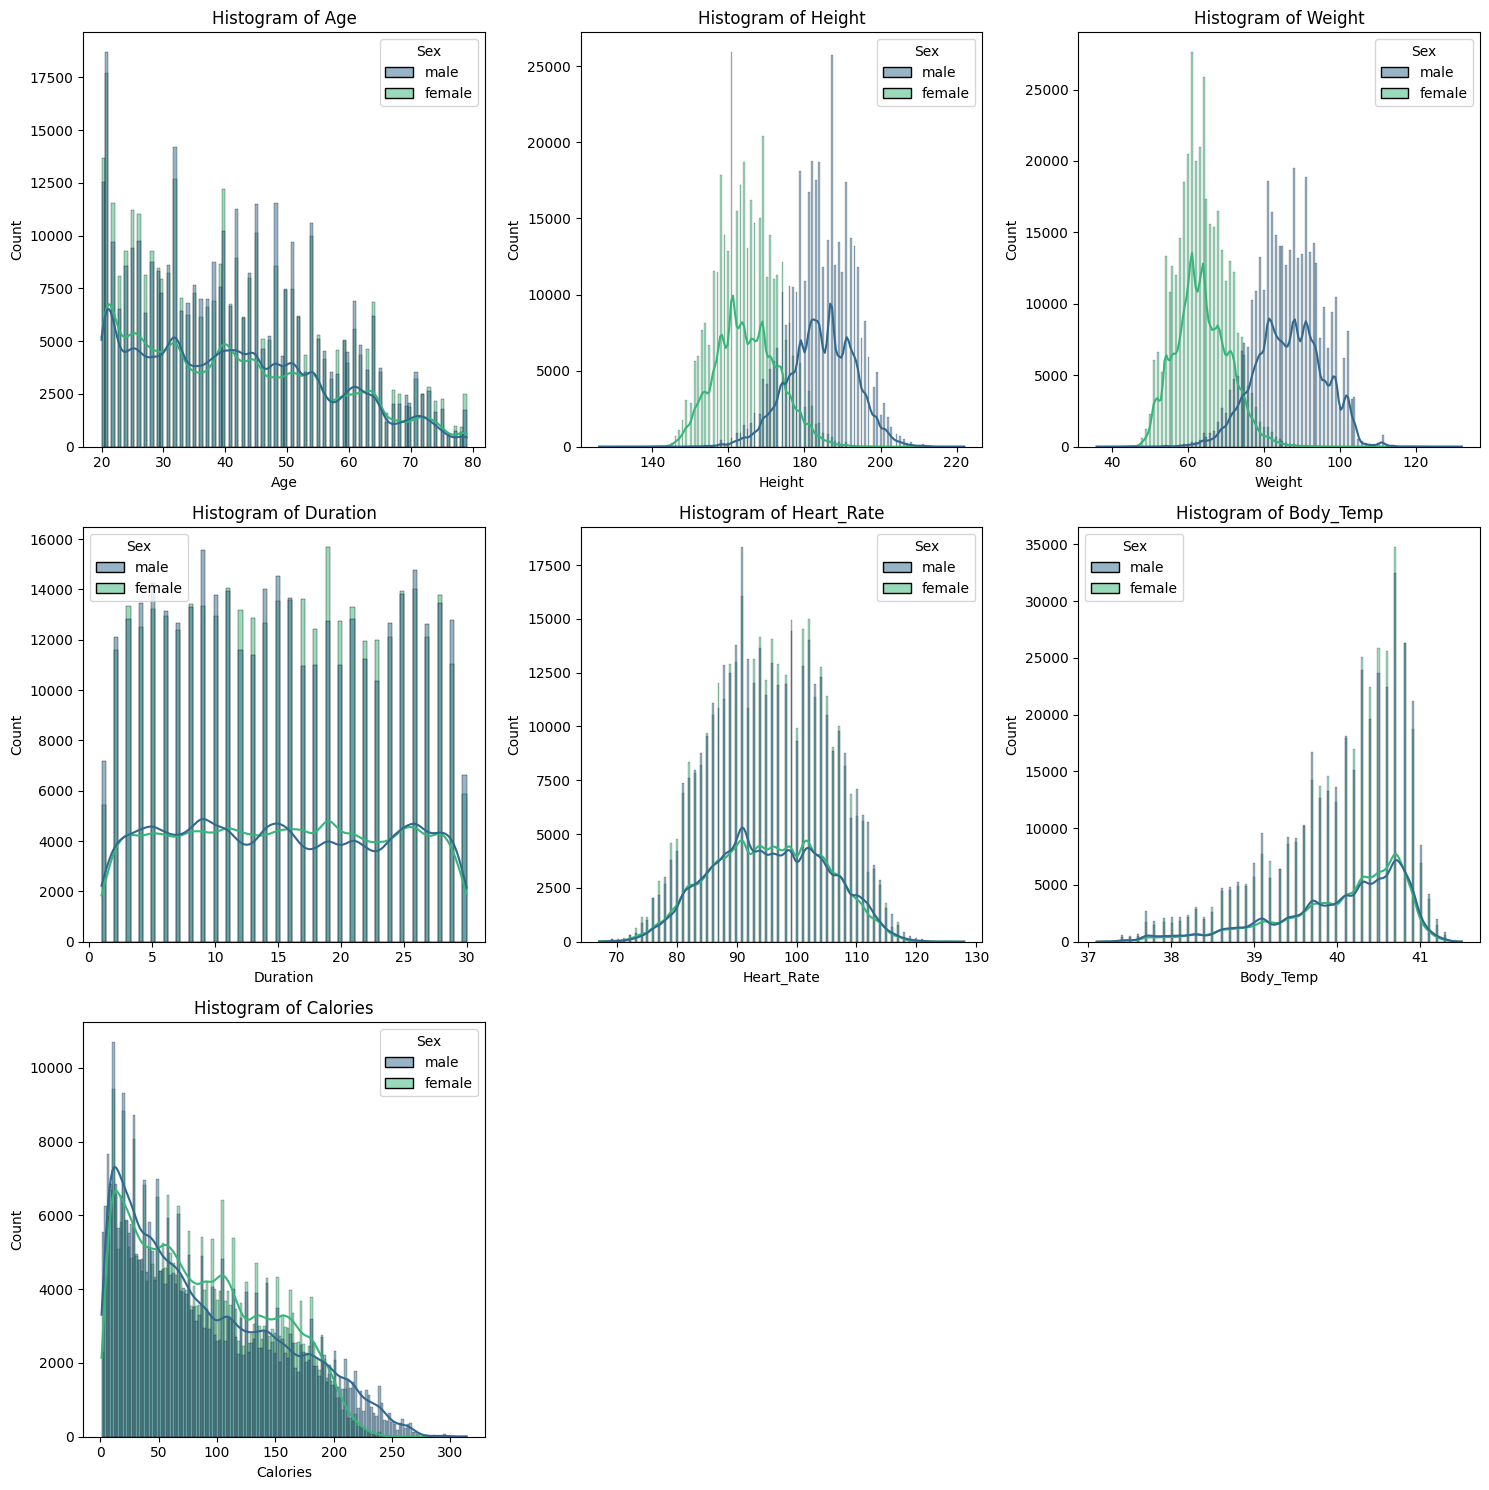

In [29]:
num_features = len(numerical_columns)
cols = 3  # Number of columns in the grid
rows = (num_features // cols) + (num_features % cols > 0)  # Dynamically determine rows

# Set figure size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()  # Flatten in case of 2D array

# Plot each feature's boxplot
for i, feature in enumerate(numerical_columns):
  sns.histplot(data=df_train, x=feature, hue='Sex', palette='viridis', kde = True, ax=axes[i])
  axes[i].set_title(f"Histogram of {feature}")

# Hide any unused subplots (if num_features < rows * cols)
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])  # Remove empty plots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

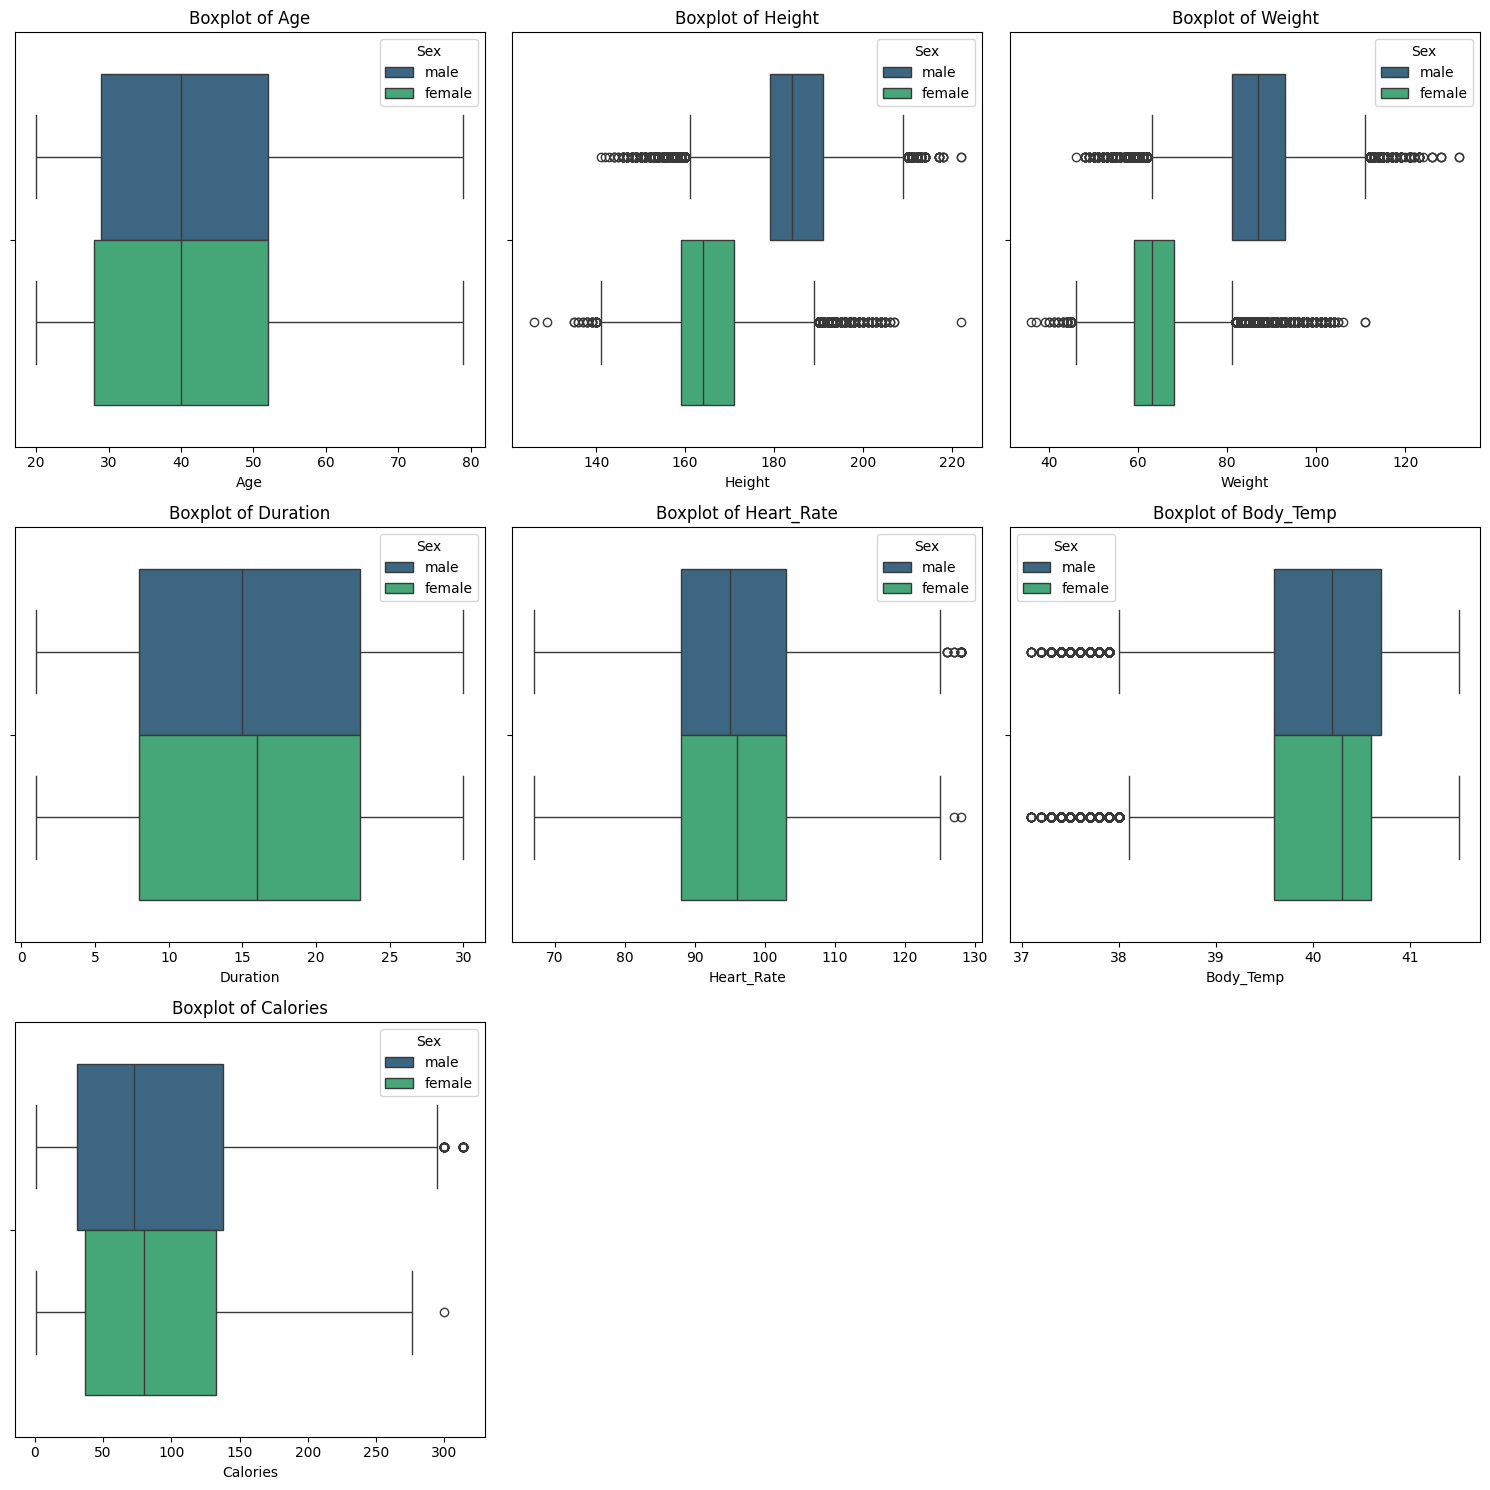

In [30]:
num_features = len(numerical_columns)
cols = 3  # Number of columns in the grid
rows = (num_features // cols) + (num_features % cols > 0)  # Dynamically determine rows

# Set figure size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()  # Flatten in case of 2D array

# Plot each feature's boxplot
for i, feature in enumerate(numerical_columns):
  sns.boxplot(data=df_train, x=feature, hue='Sex', palette='viridis', ax=axes[i])
  axes[i].set_title(f"Boxplot of {feature}")

# Hide any unused subplots (if num_features < rows * cols)
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])  # Remove empty plots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

- Women are doing longer workouts on a average, and hence buring more calories
- As expected, there is a significant gap in the height and weight distribution of the genders
- Large number of outliers for both height and wegiht in both genders. Would be interesting to see how a really tall person or heavy person differs from a shart or light person
- Women are working out longer which is probably why they have a higher heart rate and body temp

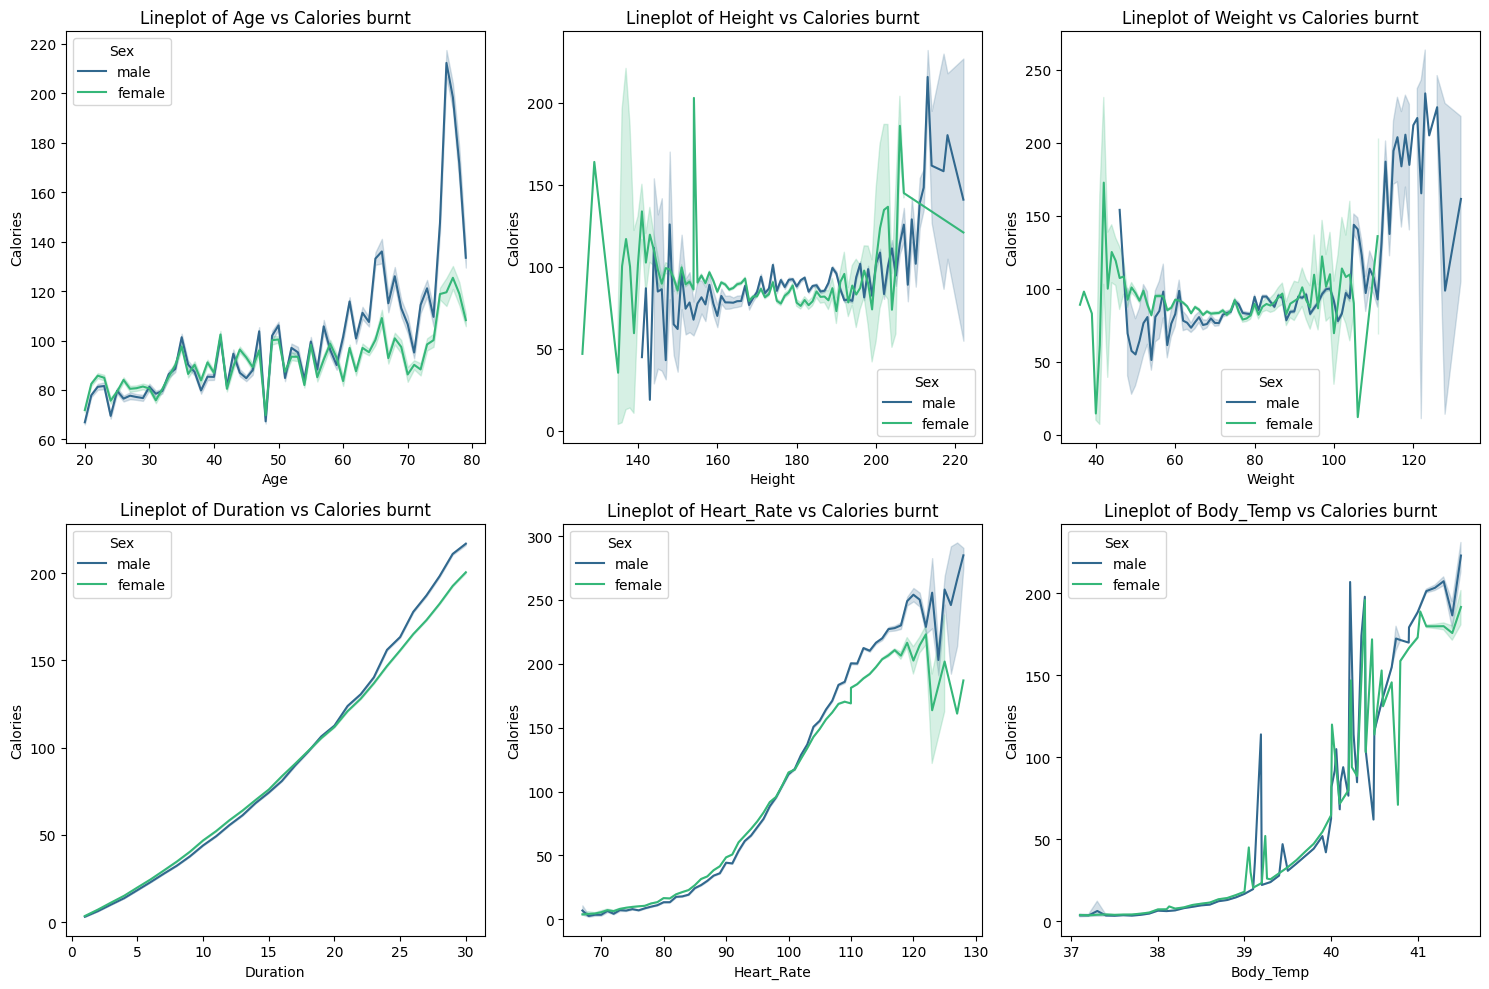

In [36]:
features = numerical_columns.remove('Calories')
num_features = len(numerical_columns)
cols = 3  # Number of columns in the grid
rows = (num_features // cols) + (num_features % cols > 0)  # Dynamically determine rows

# Set figure size
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()  # Flatten in case of 2D array

# Plot each feature's boxplot
for i, feature in enumerate(numerical_columns):
  sns.lineplot(data=df_train, x=feature, y='Calories', hue='Sex', palette='viridis', ax=axes[i])
  axes[i].set_title(f"Lineplot of {feature} vs Calories burnt")

# Hide any unused subplots (if num_features < rows * cols)
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])  # Remove empty plots

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [41]:
df_original.rename(columns={'Gender': 'Sex'}, inplace=True)
df_original.head()

,User_ID,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


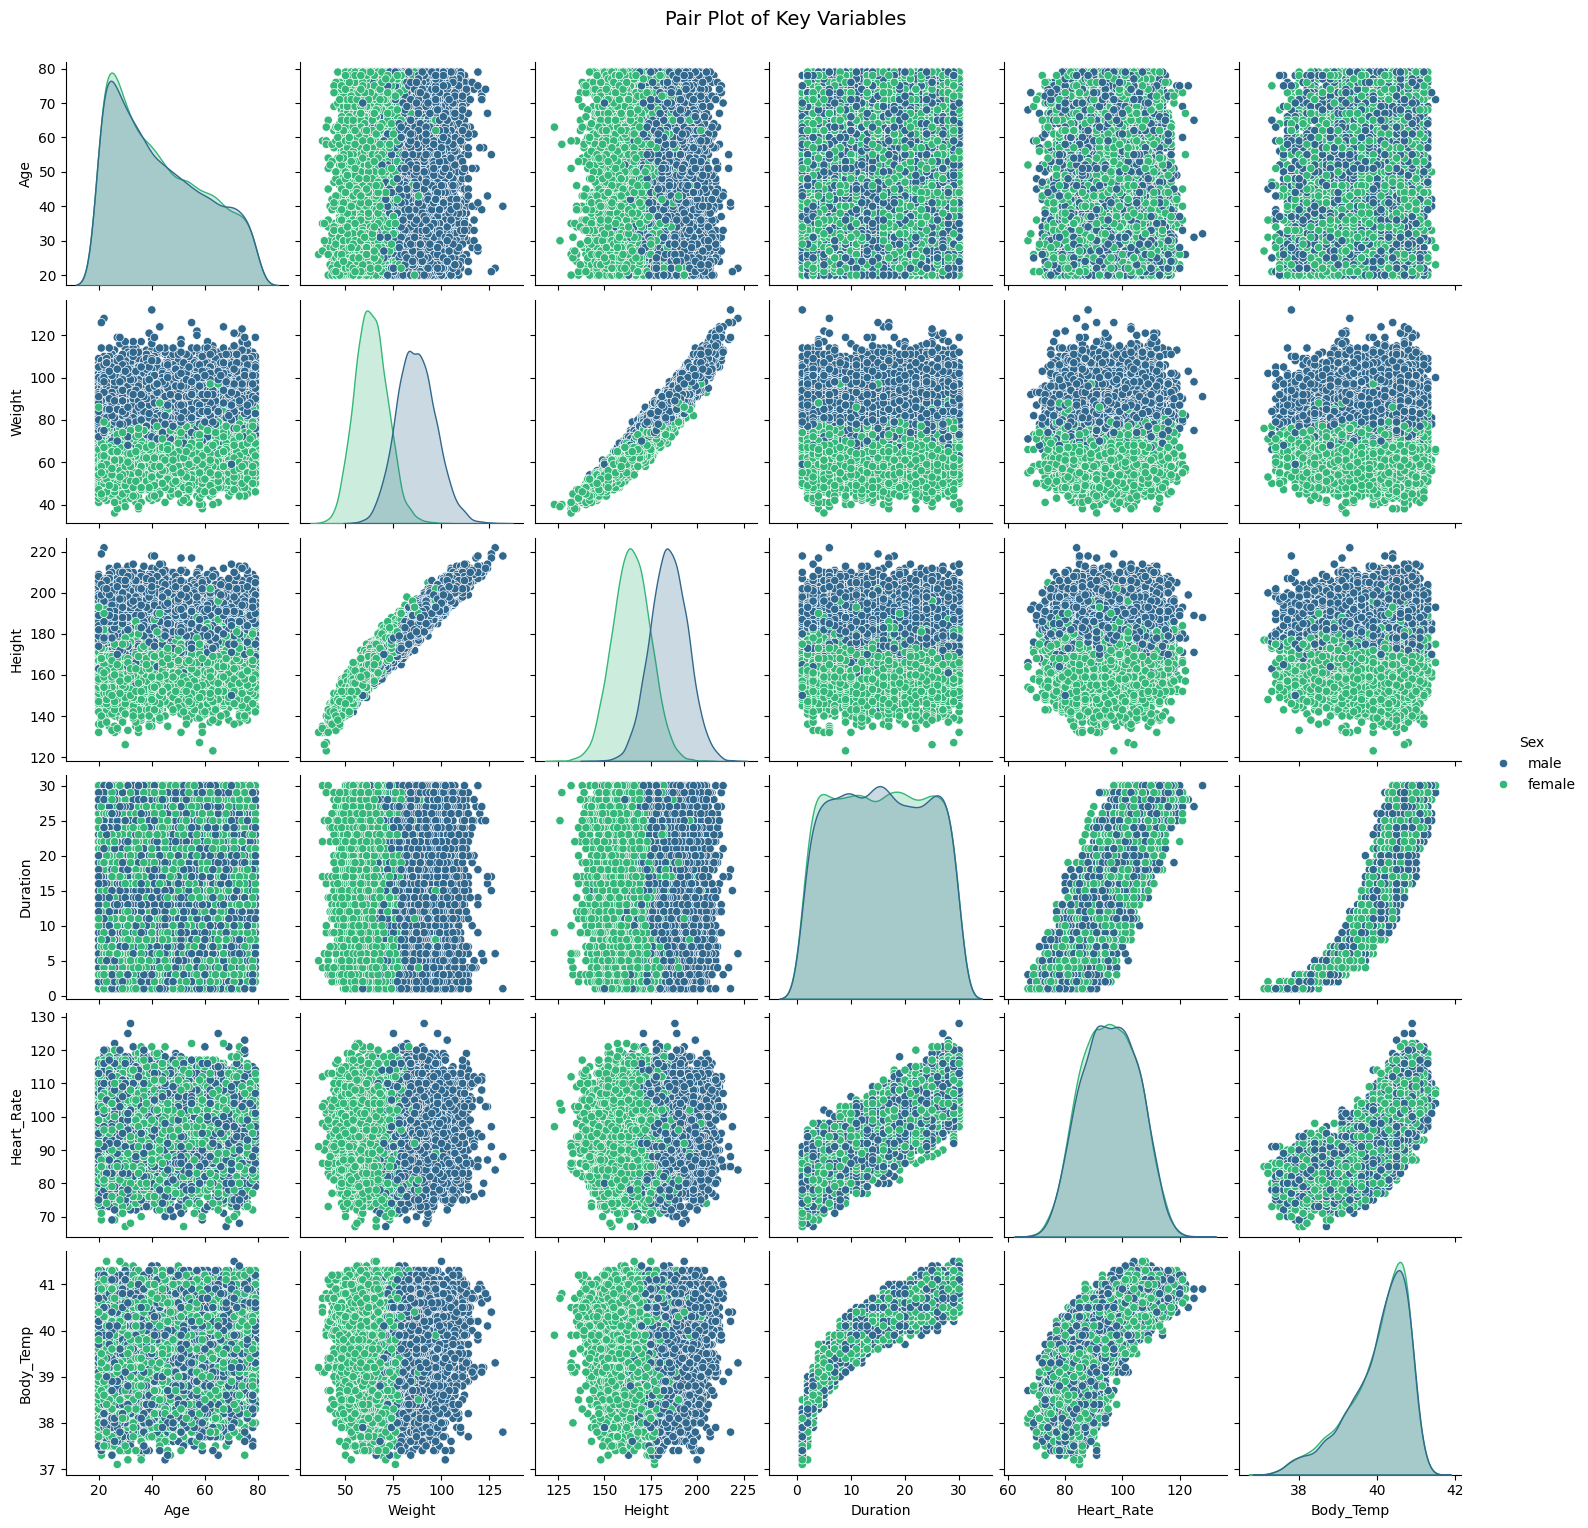

In [42]:
# running the pairplots on the original data because the training data size is computationally expensive
sns.pairplot(df_original, vars=['Age', 'Weight', 'Height', 'Duration', 'Heart_Rate', 'Body_Temp'], hue='Sex', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot of Key Variables', y=1.02, fontsize=14)
plt.show()

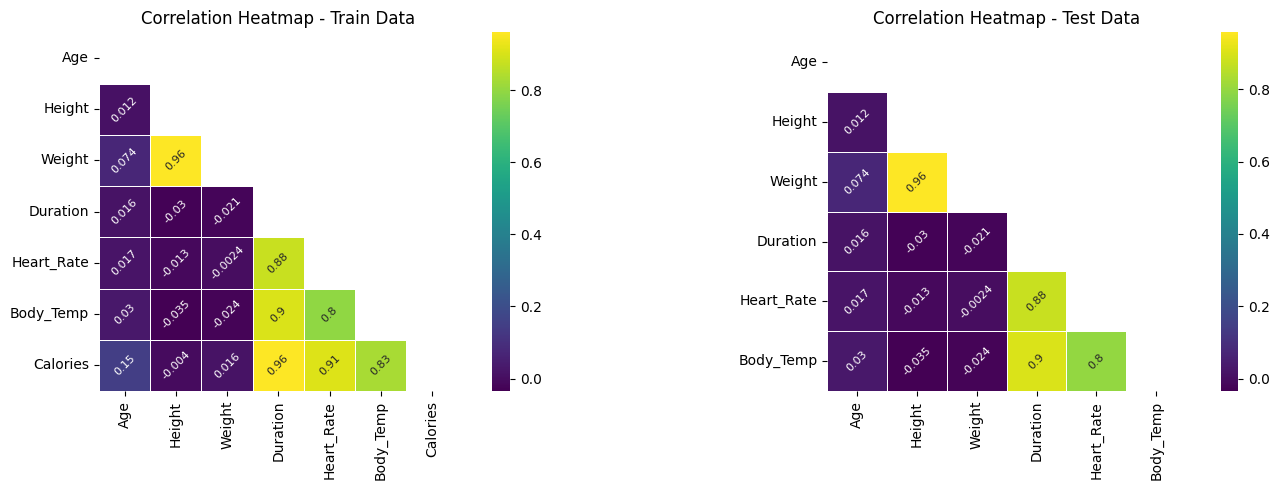

In [52]:
variables = df_train.columns.tolist()
variables.remove('id')
variables.remove('Sex')
variables.remove('Calories')

Target = 'Calories'

# Adding variables to the existing list
test_variables = variables
train_variables = variables + [Target]

# Calculate correlation matrices for train_data and test_data
corr_train = df_train[train_variables].corr()
corr_test = df_train[test_variables].corr()

# Create masks for the upper triangle
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))

# Set the text size and rotation
annot_kws = {"size": 8, "rotation": 45}

# Generate heatmaps for train_data
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax_train = sns.heatmap(corr_train, mask=mask_train, cmap='viridis', annot=True,
                      square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Train Data')

# Generate heatmaps for test_data
plt.subplot(1, 2, 2)
ax_test = sns.heatmap(corr_test, mask=mask_test, cmap='viridis', annot=True,
                     square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Test Data')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()